In [1]:
!pip install pydot==1.2.3
!apt-get install -y graphviz
!pip install pandas
!pip install -U scikit-learn
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation libann0
  libbsd0 libcairo2 libcdt5 libcgraph6 libdatrie1 libfontconfig1 libfreetype6
  libgd3 libgraphite2-3 libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libharfbuzz0b
  libice6 libjbig0 libjpeg-turbo8 libjpeg8 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libpng16-16 libsm6 libthai-data libthai0 libtiff5 libwebp6
  libx11-6 libx11-data libxau6 libxaw7 libxcb-render0 libxcb-shm0 libxcb1
  libxdmcp6 libxext6 libxmu6 libxpm4 libxrender1 libxt6 multiarch-support ucf
  x11-common
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core f

In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
from numpy import load
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# create simulated dataset
#feature_num = 40
#n_samples = 1000
#informative_num = 25
#n_clusters_per_class = 3
#n_redundant = 10
#feature_num_modality_1 = 25
#feature_num_modality_2 = 15
#n_classes = 2
#X, y = make_classification(n_samples=n_samples, n_classes=n_classes ,n_features=feature_num, n_redundant=n_redundant, n_informative=informative_num,
#                            n_clusters_per_class=n_clusters_per_class)
# fill in missing values
#mismatch = 450
#X[0:mismatch, 0:feature_num_modality_1] = np.nan
#X[-mismatch:, -feature_num_modality_2:] = np.nan
#X_overlap = X[mismatch:-mismatch]
#y_overlap = y[mismatch:-mismatch]

In [4]:
# load dataset and fill in missing values
from numpy import load
mismatch = 450
X = load('archived_data_and_results/simulation_result/X.npy')
y = load('archived_data_and_results/simulation_result/y.npy')
X_overlap = X[mismatch:-mismatch]
y_overlap = y[mismatch:-mismatch]
feature_num_modality_1 = 25
feature_num_modality_2 = 15
feature_num = 40
n_classes = 2
#X_overlap = load('simulation_result/X_overlap.npy')
#y_overlap = load('simulation_result/y_overlap.npy')

In [5]:
# Train models
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
EPOCHS = 2000
BATCH_SIZE = 256
gapnet_best_epochs = []
gapnet_train_accuracies, gapnet_val_accuracies, gapnet_test_accuracies = [], [], []
gapnet_val_aucs, gapnet_val_precisions, gapnet_val_sensitivities, gapnet_val_specificities = [], [], [], []
gapnet_val_y_preds, gapnet_val_y_labels = [], []

vanilla_best_epochs = []
vanilla_train_accuracies, vanilla_val_accuracies, vanilla_test_accuracies = [], [], []
vanilla_val_aucs, vanilla_val_precisions, vanilla_val_sensitivities, vanilla_val_specificities = [], [], [], []
vanilla_val_y_preds, vanilla_val_y_labels = [], []


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=0,
    patience=30,
    mode='auto',
    restore_best_weights=True)

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

runs = 100 #100 95 90 etc
num = int(runs / 5)

for i in range(num):
    for train_index, test_index in skf.split(X_overlap, y_overlap):
        # train/test split
        X_train, X_test = X_overlap[train_index], X_overlap[test_index]
        y_train, y_test = y_overlap[train_index], y_overlap[test_index]
    
        # wrap up the incomplete dataset
        X_modality_1 = np.concatenate((X_train[:,0:feature_num_modality_1], X[-mismatch:,0:feature_num_modality_1]), axis=0)
        Y_modality_1 = np.concatenate((y_train, y[-mismatch:]), axis=0)
        X_modality_2 = np.concatenate((X_train[:,-feature_num_modality_2:], X[0:mismatch,-feature_num_modality_2:]), axis=0)
        Y_modality_2 = np.concatenate((y_train, y[0:mismatch]), axis=0)
    
        # split train dataset
        X_train_for_modality_1 = X_train[:,0:feature_num_modality_1]
        X_train_for_modality_2 = X_train[:,-feature_num_modality_2:]
        X_test_for_modality_1 = X_test[:,0:feature_num_modality_1]
        X_test_for_modality_2 = X_test[:,-feature_num_modality_2:]
    
        # normalization
        thres = 20
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_train = np.clip(X_train, -thres, thres)
        X_test = np.clip(X_test, -thres, thres)
    
        X_modality_1 = scaler.fit_transform(X_modality_1)
        X_train_for_modality_1 = scaler.transform(X_train_for_modality_1)
        X_test_for_modality_1 = scaler.transform(X_test_for_modality_1)
    
        X_modality_1 = np.clip(X_modality_1, -thres, thres)
        X_train_for_modality_1 = np.clip(X_train_for_modality_1, -thres, thres)
        X_test_for_modality_1 = np.clip(X_test_for_modality_1, -thres, thres)
    
        X__modality_2 = scaler.fit_transform(X_modality_2)
        X_train_for_modality_2 = scaler.transform(X_train_for_modality_2)
        X_test_for_modality_2 = scaler.transform(X_test_for_modality_2)
    
        X_modality_2 = np.clip(X_modality_2, -thres, thres)
        X_train_for_modality_2 = np.clip(X_train_for_modality_2, -thres, thres)
        X_test_for_modality_2 = np.clip(X_test_for_modality_2, -thres, thres)
    
        # vanilla model building
        input_0 = tf.keras.layers.Input(shape=(feature_num,))
        hidden_0 = tf.keras.layers.Dense(2*feature_num, activation="relu")
        hidden_1 = tf.keras.layers.Dense(2*feature_num, activation="relu")
        outputs_0_pretrained = (hidden_0)(input_0)
        outputs_0_pretrained = (hidden_1)(outputs_0_pretrained)
        outputs_0 = tf.keras.layers.Dropout(0.5)(outputs_0_pretrained)
        outputs_0 = tf.keras.layers.Dense(n_classes, activation="softmax")(outputs_0)
        model_0 = tf.keras.Model(inputs=input_0, outputs=[outputs_0])
        model_0.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)
    
        print('vanilla model training...')
        vanilla_history = model_0.fit(X_train, to_categorical(y_train), epochs=EPOCHS, verbose=0,
        callbacks=[early_stopping],
        validation_data=(X_test, to_categorical(y_test)))
        print('vanilla model trained')
    
        # GapNet model building
        ## model 1
        input_1 = tf.keras.layers.Input(shape=(feature_num_modality_1,))
        hidden_1 = tf.keras.layers.Dense(2*feature_num_modality_1, activation="relu")
        hidden_1_1 = tf.keras.layers.Dense(2*feature_num, activation="relu")
        outputs_1_pretrained = (hidden_1)(input_1)
        outputs_1_pretrained = (hidden_1_1)(outputs_1_pretrained)
        outputs_1 = tf.keras.layers.Dropout(0.5)(outputs_1_pretrained)
        outputs_1 = tf.keras.layers.Dense(n_classes, activation="softmax")(outputs_1)
        model_1 = tf.keras.Model(inputs=input_1, outputs=[outputs_1])
        model_1.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
        print('gapnet 1st model training...')
        model_1.fit(X_modality_1, to_categorical(Y_modality_1), epochs=EPOCHS, verbose=0,
        callbacks=[early_stopping],
        validation_data=(X_test_for_modality_1, to_categorical(y_test)))
        print('gapnet 1st model trained')
    
        ## model 2
        input_2 = tf.keras.layers.Input(shape=(feature_num_modality_2,))
        hidden_2 = tf.keras.layers.Dense(2*feature_num_modality_2, activation="relu")
        hidden_2_1 = tf.keras.layers.Dense(2*feature_num_modality_2, activation="relu")
        outputs_2_pretrained = (hidden_2)(input_2)
        outputs_2_pretrained = (hidden_2_1)(outputs_2_pretrained)
        outputs_2 = tf.keras.layers.Dropout(0.5)(outputs_2_pretrained)
        outputs_2 = tf.keras.layers.Dense(n_classes, activation="softmax")(outputs_2)
        model_2 = tf.keras.Model(inputs=input_2, outputs=[outputs_2])
        model_2.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
        print('gapnet 2nd model training...')
        model_2.fit(X_modality_2, to_categorical(Y_modality_2), epochs=EPOCHS, verbose=0,
        callbacks=[early_stopping],
        validation_data=(X_test_for_modality_2, to_categorical(y_test)))
        print('gapnet 2nd model trained')
    
        ## models concatenating
        concat = tf.keras.layers.Concatenate()([outputs_1_pretrained, outputs_2_pretrained])
        output_con = tf.keras.layers.Dropout(0.0)(concat)
        output_con = tf.keras.layers.Dense(units=n_classes, activation=tf.keras.activations.softmax, name="output_con")(output_con)
        full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output_con])
        hidden_2.trainable = False
        hidden_1.trainable = False
        full_model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
    
        print('gapnet full model training...')
        gapnet_history = full_model.fit(
        [X_train_for_modality_1, X_train_for_modality_2],
        to_categorical(y_train),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, verbose=0,
        callbacks=[early_stopping],
        validation_data=([X_test_for_modality_1, X_test_for_modality_2], to_categorical(y_test)))
        print('gapnet full model trained')
    
        # score recording
        ## gapnet
        best_epoch = np.argmin(gapnet_history.history['val_loss'])+1
        train_accuracy = gapnet_history.history['accuracy'][best_epoch-1]
        val_y_pred = full_model.predict([X_test_for_modality_1, X_test_for_modality_2])
        threshold = 0.5
        val_y_pred_class = np.where(val_y_pred>threshold, 1, 0)
        m = tf.keras.metrics.TruePositives()
        m.update_state(val_y_pred_class[:,1], y_test)
        val_tp = m.result().numpy()
        m = tf.keras.metrics.TrueNegatives()
        m.update_state(val_y_pred_class[:,1], y_test)
        val_tn = m.result().numpy()
        m = tf.keras.metrics.FalsePositives()
        m.update_state(val_y_pred_class[:,1], y_test)
        val_fp = m.result().numpy()
        m = tf.keras.metrics.FalseNegatives()
        m.update_state(val_y_pred_class[:,1], y_test)
        val_fn = m.result().numpy()
        val_accuracy = (val_tp+val_tn)/(val_tp+val_tn+val_fp+val_fn)
        val_sensitivity = (val_tp)/(val_tp+val_fn)
        val_specificity = (val_tn)/(val_tn+val_fp)
        val_precision = (val_tp)/(val_tp+val_fp)
        val_auc = roc_auc_score(y_test, val_y_pred[:,1])
        
        
        gapnet_best_epochs.append(best_epoch)
        gapnet_train_accuracies.append(train_accuracy)
        gapnet_val_accuracies.append(val_accuracy)
        gapnet_val_aucs.append(val_auc)
        gapnet_val_precisions.append(val_precision)
        gapnet_val_sensitivities.append(val_sensitivity)
        gapnet_val_specificities.append(val_specificity)
        #gapnet_val_y_preds.append(val_y_pred[:,1])
        gapnet_val_y_preds = np.append(gapnet_val_y_preds, val_y_pred[:,1])
        #gapnet_val_y_labels.append(y_test)
        gapnet_val_y_labels = np.append(gapnet_val_y_labels, y_test)
    
        ## vanilla
        best_epoch = np.argmin(vanilla_history.history['val_loss'])+1
        train_accuracy = vanilla_history.history['accuracy'][best_epoch-1]
        val_auc = vanilla_history.history['val_auc'][best_epoch-1]
        val_y_pred = model_0.predict(X_test)
        threshold = 0.5
        val_y_pred_class = np.where(val_y_pred>threshold, 1, 0)
        m = tf.keras.metrics.TruePositives()
        m.update_state(val_y_pred_class[:,1], y_test)
        val_tp = m.result().numpy()
        m = tf.keras.metrics.TrueNegatives()
        m.update_state(val_y_pred_class[:,1], y_test)
        val_tn = m.result().numpy()
        m = tf.keras.metrics.FalsePositives()
        m.update_state(val_y_pred_class[:,1], y_test)
        val_fp = m.result().numpy()
        m = tf.keras.metrics.FalseNegatives()
        m.update_state(val_y_pred_class[:,1], y_test)
        val_fn = m.result().numpy()
        
        val_accuracy = (val_tp+val_tn)/(val_tp+val_tn+val_fp+val_fn)
        val_sensitivity = (val_tp)/(val_tp+val_fn)
        val_specificity = (val_tn)/(val_tn+val_fp)
        val_precision = (val_tp)/(val_tp+val_fp)
        val_auc = roc_auc_score(y_test, val_y_pred[:,1])
        
        vanilla_best_epochs.append(best_epoch)
        vanilla_train_accuracies.append(train_accuracy)
        vanilla_val_accuracies.append(val_accuracy)
        vanilla_val_aucs.append(val_auc)
        vanilla_val_precisions.append(val_precision)
        vanilla_val_sensitivities.append(val_sensitivity)
        vanilla_val_specificities.append(val_specificity)
        vanilla_val_y_preds = np.append(vanilla_val_y_preds,val_y_pred[:,1])
        vanilla_val_y_labels = np.append(vanilla_val_y_labels, y_test)
    
        print(fold, ' fold(s) finished')
        fold+=1
        print("GapNet Results :")
        print("best_epochs {}".format(gapnet_best_epochs))
        print("train_accuracy {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_train_accuracies), np.std(gapnet_train_accuracies), np.round(gapnet_train_accuracies, 3)))
        print("val_accuracy {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_accuracies), np.std(gapnet_val_accuracies), np.round(gapnet_val_accuracies, 3)))
        print("val_auc {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_aucs), np.std(gapnet_val_aucs), np.round(gapnet_val_aucs, 3)))
        print("val_sens {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_sensitivities), np.std(gapnet_val_sensitivities), np.round(gapnet_val_sensitivities, 3)))
        print("val_spec {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_specificities), np.std(gapnet_val_specificities), np.round(gapnet_val_specificities, 3)))
        print("val_prec {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_precisions), np.std(gapnet_val_precisions), np.round(gapnet_val_precisions, 3)))
        print("Vanilla Results :")
        print("best_epochs {}".format(vanilla_best_epochs))
        print("train_accuracy {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_train_accuracies), np.std(vanilla_train_accuracies), np.round(vanilla_train_accuracies, 3)))
        print("val_accuracy {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_accuracies), np.std(vanilla_val_accuracies), np.round(vanilla_val_accuracies, 3)))
        print("val_auc {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_aucs), np.std(vanilla_val_aucs), np.round(vanilla_val_aucs, 3)))
        print("val_sens {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_sensitivities), np.std(vanilla_val_sensitivities), np.round(vanilla_val_sensitivities, 3)))
        print("val_spec {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_specificities), np.std(vanilla_val_specificities), np.round(vanilla_val_specificities, 3)))
        print("val_prec {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_precisions), np.std(vanilla_val_precisions), np.round(vanilla_val_precisions, 3)))

vanilla model training...
vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
1  fold(s) finished
GapNet Results :
best_epochs [94]
train_accuracy 0.988+/-0.000 : [0.988]
val_accuracy 0.900+/-0.000 : [0.9]
val_auc 0.890+/-0.000 : [0.89]
val_sens 0.900+/-0.000 : [0.9]
val_spec 0.900+/-0.000 : [0.9]
val_prec 0.900+/-0.000 : [0.9]
Vanilla Results :
best_epochs [6]
train_accuracy 0.650+/-0.000 : [0.65]
val_accuracy 0.500+/-0.000 : [0.5]
val_auc 0.610+/-0.000 : [0.61]
val_sens 0.500+/-0.000 : [0.5]
val_spec 0.500+/-0.000 : [0.5]
val_prec 0.400+/-0.000 : [0.4]
vanilla model training...
vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
2  fold(s) finished
GapNet Results :
best_epochs [94, 161]
train_accuracy 0.994+/-0.006 : [0.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
6  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136]
train_accuracy 0.933+/-0.138 : [0.988 1.    0.625 0.988 1.    1.   ]
val_accuracy 0.817+/-0.167 : [0.9  0.95 0.45 0.85 0.85 0.9 ]
val_auc 0.867+/-0.188 : [0.89  1.    0.455 0.919 0.98  0.96 ]
val_sens 0.800+/-0.175 : [0.9   0.909 0.417 0.8   0.875 0.9  ]
val_spec 0.839+/-0.159 : [0.9   1.    0.5   0.9   0.833 0.9  ]
val_prec 0.837+/-0.141 : [0.9   1.    0.556 0.889 0.778 0.9  ]
Vanilla Results :
best_epochs [6, 27, 2, 4, 31, 18]
train_accuracy 0.771+/-0.167 : [0.65  0.988 0.512 0.7   0.95  0.825]
val_accuracy 0.575+/-0.155 : [0.5  0.65 0.45 0.35 0.8  0.7 ]
val_auc 0.581+/-0.207 : [0.61  0.74  0.343 0.283 0.869 0.64 ]
val_sens 0.510+/-0.258 : [0.5   0.667 0.417 0.    0.727 0.75 ]
val_spec 0.605+/-0.150 : [0.5   0.636 0.5   0.438 

9  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72]
train_accuracy 0.954+/-0.117 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.   ]
val_accuracy 0.828+/-0.151 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95]
val_auc 0.871+/-0.173 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949]
val_sens 0.815+/-0.170 : [0.9   0.909 0.417 0.8   0.875 0.9   1.    0.636 0.9  ]
val_spec 0.849+/-0.142 : [0.9   1.    0.5   0.9   0.833 0.9   0.833 0.778 1.   ]
val_prec 0.844+/-0.129 : [0.9   1.    0.556 0.889 0.778 0.9   0.8   0.778 1.   ]
Vanilla Results :
best_epochs [6, 27, 2, 4, 31, 18, 29, 1, 4]
train_accuracy 0.754+/-0.178 : [0.65  0.988 0.512 0.7   0.95  0.825 0.988 0.54  0.637]
val_accuracy 0.611+/-0.141 : [0.5  0.65 0.45 0.35 0.8  0.7  0.6  0.75 0.7 ]
val_auc 0.643+/-0.193 : [0.61  0.74  0.343 0.283 0.869 0.64  0.79  0.808 0.707]
val_sens 0.576+/-0.236 : [0.5   0.667 0.417 0.    0.727 0.75  0.625 0.833 0.667]
val_spec 0.628+/-0.132 : [0.5   0.636 0

12  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361]
train_accuracy 0.956+/-0.104 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.   ]
val_accuracy 0.829+/-0.139 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9 ]
val_auc 0.886+/-0.155 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96 ]
val_sens 0.831+/-0.158 : [0.9   0.909 0.417 0.8   0.875 0.9   1.    0.636 0.9   0.889 0.75  1.   ]
val_spec 0.838+/-0.134 : [0.9   1.    0.5   0.9   0.833 0.9   0.833 0.778 1.    0.909 0.667 0.833]
val_prec 0.824+/-0.132 : [0.9   1.    0.556 0.889 0.778 0.9   0.8   0.778 1.    0.889 0.6   0.8  ]
Vanilla Results :
best_epochs [6, 27, 2, 4, 31, 18, 29, 1, 4, 42, 21, 69]
train_accuracy 0.809+/-0.181 : [0.65  0.988 0.512 0.7   0.95  0.825 0.988 0.54  0.637 0.988 0.925 1.   ]
val_accuracy 0.642+/-0.134 : [0.5  0.65 0.45 0.35 0.8  0.7  0.6  0.75 0.7  0.75 0.7  0.75]
val_auc 0.696+/-0.191 : [0.61  0.74

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
15  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797]
train_accuracy 0.960+/-0.094 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.   ]
val_accuracy 0.820+/-0.138 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95]
val_auc 0.877+/-0.149 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.   ]
val_sens 0.818+/-0.163 : [0.9   0.909 0.417 0.8   0.875 0.9   1.    0.636 0.9   0.889 0.75  1.
 0.6   0.7   1.   ]
val_spec 0.831+/-0.127 : [0.9   1.    0.5   0.9   0.833 0.9   0.833 0.778 1.    0.909 0.667 0.833
 0.7   0.8   0.917]
val_prec 0.815+/-0.126 : [0.9   1.    0.556 0.889 0.778 0.9   0.8   0.778 1.    0.889 0.6   0.8
 0.667 0.778 0.889]
Vani

17  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469]
train_accuracy 0.964+/-0.089 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.   ]
val_accuracy 0.829+/-0.136 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.  ]
val_auc 0.883+/-0.143 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.   ]
val_sens 0.828+/-0.159 : [0.9   0.909 0.417 0.8   0.875 0.9   1.    0.636 0.9   0.889 0.75  1.
 0.6   0.7   1.    0.8   1.   ]
val_spec 0.839+/-0.126 : [0.9   1.    0.5   0.9   0.833 0.9   0.833 0.778 1.    0.909 0.667 0.833
 0.7   0.8   0.917 0.8   1.   ]
val_prec 0.825+/-0.127 : [0.9   1.    0.556 0.889 0.778 0.9   0.8   0.778 1.    0.889 0.6   0.8
 0.667 0.778 0.889 0.8   1.   ]
Vanilla Results :
best_epochs [6, 27, 2, 4, 31, 18, 29, 1, 4, 42, 21, 69, 4, 10, 36, 9, 38]
train_accuracy 0.81

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
20  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423]
train_accuracy 0.966+/-0.083 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.   ]
val_accuracy 0.823+/-0.133 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9 ]
val_auc 0.885+/-0.137 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    0.768 0.939 0.99 ]
val_sens 0.814+/-0.158 : [0.9   0.909 0.417 0.8   0.875 0.9   1.    0.636 0.9   0.889 0.75  1.
 0.6   0.7   1.    0.8   1.    0.583 0.727 0.889]
val_spec 0.841+/-0.120 : [0.9   1.    0.5   0.9   0.833 0.9   0.833 0.778 1.    0.909 0.667 0.833
 0.

22  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100]
train_accuracy 0.966+/-0.080 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.   ]
val_accuracy 0.820+/-0.128 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85]
val_auc 0.889+/-0.133 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    0.768 0.939 0.99  0.87  0.98 ]
val_sens 0.812+/-0.151 : [0.9   0.909 0.417 0.8   0.875 0.9   1.    0.636 0.9   0.889 0.75  1.
 0.6   0.7   1.    0.8   1.    0.583 0.727 0.889 0.778 0.818]
val_spec 0.838+/-0.117 : [0.9   1.    0.5   0.9   0.833 0.9   0.833 0.778 1.    0.909 0.667 0.833
 0.7   0.8   0.917 0.8   1.    0.75  0.889 0.909 0.727 0.889]
val_prec 0.826+/-0.118 : [0.9   1.    0.556 0.889 0.778 0.9   0.8   0.77

24  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67]
train_accuracy 0.967+/-0.077 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962]
val_accuracy 0.810+/-0.130 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8 ]
val_auc 0.880+/-0.130 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    0.768 0.939 0.99  0.87  0.98  0.747 0.828]
val_sens 0.797+/-0.155 : [0.9   0.909 0.417 0.8   0.875 0.9   1.    0.636 0.9   0.889 0.75  1.
 0.6   0.7   1.    0.8   1.    0.583 0.727 0.889 0.778 0.818 0.538 0.727]
val_spec 0.835+/-0.115 : [0.9   1.    0.5   0.9   0.833 0.9   0.833 0.778 1.    0.909 0.667 0.833
 0.7   0.8   0.917 0.8   1.    0.75  0.889 0.909 0.727 0.889 0.714 0.889]
val_pr

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
27  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184]
train_accuracy 0.969+/-0.073 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.   ]
val_accuracy 0.820+/-0.131 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95]
val_auc 0.887+/-0.125 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    0.768 0.939 0.99  0.87  0.98  0.747 0.828
 1.    0.87  0.94 ]
val_sens 0.812+/-0.156 : [0.9   0.909 0.417 0.8   0.875 0.9   1.    0.636 0.9   0.889 0.75  1

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
29  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42]
train_accuracy 0.967+/-0.071 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962]
val_accuracy 0.812+/-0.140 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9 ]
val_auc 0.878+/-0.129 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    0.768 0.939 0.99  0.87  0.98  0.747 0.828
 1.    0.87  0.94  0.636 0.879]
val_sens 0.799+/-0.166 : [0.9   0.909 0.417 0.8   0

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
31  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34]
train_accuracy 0.967+/-0.069 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938]
val_accuracy 0.816+/-0.140 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75]
val_auc 0.878+/-0.128 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    0.768 0.939 0.99  0.87  0.98  0.747 0.828
 1.    0.87  0.94  0.636 0.879 1.    0.78 ]
val_sens

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
33  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25]
train_accuracy 0.967+/-0.067 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95 ]
val_accuracy 0.812+/-0.141 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6 ]
val_auc 0.878+/-0.128 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    0.768 0.939 0.99  0.87  0.98  0.747 0.828
 1.    0.87  0.94  0.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
35  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164]
train_accuracy 0.968+/-0.065 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988]
val_accuracy 0.813+/-0.137 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85]
val_auc 0.881+/-0.126 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    0.768 0.939 0.99  0.87  0.98  0.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
37  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477]
train_accuracy 0.968+/-0.064 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.   ]
val_accuracy 0.818+/-0.137 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.  ]
val_auc 0.884+/-0.124 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 0.727 0.798 1.    0.85  1.    

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
39  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53]
train_accuracy 0.968+/-0.063 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988]
val_accuracy 0.814+/-0.135 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7  0.8 ]
val_auc 0.881+/-0.122 : [0.89  1.    0.455 0.919 0.98  0.96  1.    0.687 0.949 0.99  0.84  0.96
 

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
41  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84]
train_accuracy 0.969+/-0.061 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.   ]
val_accuracy 0.817+/-0.132 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7  0.8  0.9  0.85]
val_auc 0.885+/-0.120 : [0.89  1.    0.455 0.919 0.98  0.96  1.    

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
43  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29]
train_accuracy 0.969+/-0.061 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925]
val_accuracy 0.815+/-0.132 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7  0.8  0.9  0.85 0.9
 0.65]
val_auc 0.880+/-0.126 : [0.89  1.   

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
45  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000]
train_accuracy 0.970+/-0.059 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.   ]
val_accuracy 0.820+/-0.132 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7  0.8  0.9  0.85 0.9
 0.65 0.85 1.  ]
val_

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
47  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101]
train_accuracy 0.971+/-0.058 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.   ]
val_accuracy 0.820+/-0.130 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7  0.8  0.9  0.85 0.9


vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
49  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75]
train_accuracy 0.972+/-0.057 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.   ]
val_accuracy 0.819+/-0.127 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
51  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61]
train_accuracy 0.973+/-0.056 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.   ]
val_accuracy 0.822+/-0.126 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
53  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31]
train_accuracy 0.973+/-0.056 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962]
val_accuracy 0.820+/-0.129 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
55  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171]
train_accuracy 0.974+/-0.055 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.   ]
val_accuracy 0.821+/-0.127 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
57  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444]
train_accuracy 0.975+/-0.054 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.   ]
val_accuracy 0.825+/-0.126 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75

58  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15]
train_accuracy 0.974+/-0.054 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925]
val_accuracy 0.823+/-0.125 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7  0.8  0.9  0.85 0.9
 0.65 0.85 1.   0.8  0.85 0.75 0.85 0.95 0.8  0.95 0.6  0.8  0.9  0.9
 

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
60  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274]
train_accuracy 0.975+/-0.053 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.   ]
val_accuracy 0.825+/-0.124 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.9

61  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80]
train_accuracy 0.975+/-0.053 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.   ]
val_accuracy 0.825+/-0.123 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7  0.8  0.9  0.85 0.9
 0.65 0.85 1.   0.8  0.85 0.75 0.85 0.95 0

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
63  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21]
train_accuracy 0.975+/-0.053 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913]
val_accuracy 0.821+/-0.124 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 

64  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116]
train_accuracy 0.975+/-0.052 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.   ]
val_accuracy 0.821+/-0.123 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   0.7  0.8  0.9  0.85 0.9
 0.65 0.85

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
66  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78]
train_accuracy 0.976+/-0.052 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.   ]
val_accuracy 0.824+/-0.123 : [0.9  0.95 0.

67  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000]
train_accuracy 0.976+/-0.051 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.   ]
val_accuracy 0.827+/-0.124 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75 0.9  0.6  0.8  0.85 0.8  1.   

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
69  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77]
train_accuracy 0.976+/-0.051 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988]
val_accura

70  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199]
train_accuracy 0.976+/-0.050 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988 1.   ]
val_accuracy 0.826+/-0.124 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9  1.   0.75

71  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69]
train_accuracy 0.977+/-0.050 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988 1.    1.   ]
val_accuracy 0.827+/-0.123 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6  0.8  1.   0.75 0.95 0.5
 0.9 

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
73  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8]
train_accuracy 0.971+/-0.068 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0

74  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97]
train_accuracy 0.971+/-0.068 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988 1.    1.    0.988
 0.575 0.988]
val_accuracy 0.822+/-0.129 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.75 0.85 0.6 

75  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126]
train_accuracy 0.972+/-0.067 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988 1.    1.    0.988
 0.575 0.988 1.   ]
val_accuracy 0.824+/-0.129 : [0.9  0.95 0.45 0.85 0.85 0.9  0.9  0.7  0.95 0.9  0.7  0.9  0.65 0.75
 0.95 0.8  1.   0.65 0.8  0.9  0.7

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
77  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000]
train_accuracy 0.972+/-0.067 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    

gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
78  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16]
train_accuracy 0.969+/-0.069 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988 1.    1.    0.988
 0.575 0.988 1.    0.938 1.    0.788]
val_accuracy 0.821+/-

gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
79  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59]
train_accuracy 0.969+/-0.069 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988 1.    1.    0.988
 0.575 0.988 1.    0.938 1.    0.788 0.962]
val_accurac

gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
80  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214]
train_accuracy 0.970+/-0.069 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988 1.    1.    0.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
81  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46]
train_accuracy 0.970+/-0.068 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
82  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359]
train_accuracy 0.970+/-0.068 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
83  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33]
train_accuracy 0.970+/-0.067 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.  

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
84  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95]
train_accuracy 0.971+/-0.067 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
85  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426]
train_accuracy 0.971+/-0.067 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
86  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52]
train_accuracy 0.971+/-0.066 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
87  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60]
train_accuracy 0.971+/-0.066 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.9

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
88  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39]
train_accuracy 0.971+/-0.066 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.   

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
89  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50]
train_accuracy 0.971+/-0.065 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
90  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119]
train_accuracy 0.972+/-0.065 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
91  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51]
train_accuracy 0.972+/-0.065 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.  

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
92  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000]
train_accuracy 0.972+/-0.064 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.  

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
93  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20]
train_accuracy 0.972+/-0.064 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
94  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20, 41]
train_accuracy 0.972+/-0.064 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
95  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20, 41, 131]
train_accuracy 0.972+/-0.063 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1. 

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
96  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20, 41, 131, 65]
train_accuracy 0.972+/-0.063 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.   

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
97  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20, 41, 131, 65, 179]
train_accuracy 0.973+/-0.063 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
98  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20, 41, 131, 65, 179, 28]
train_accuracy 0.972+/-0.063 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.

vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
99  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20, 41, 131, 65, 179, 28, 68]
train_accuracy 0.972+/-0.063 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.  

vanilla model training...
vanilla model trained
gapnet 1st model training...
gapnet 1st model trained
gapnet 2nd model training...
gapnet 2nd model trained
gapnet full model training...
gapnet full model trained
100  fold(s) finished
GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20, 41, 131, 65, 179, 28, 68, 855]
train_accuracy 0.972+/-0.062 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.9

In [6]:
print("GapNet Results :")
print("best_epochs {}".format(gapnet_best_epochs))
print("train_accuracy {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_train_accuracies), np.std(gapnet_train_accuracies), np.round(gapnet_train_accuracies, 3)))
print("val_accuracy {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_accuracies), np.std(gapnet_val_accuracies), np.round(gapnet_val_accuracies, 3)))
print("val_auc {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_aucs), np.std(gapnet_val_aucs), np.round(gapnet_val_aucs, 3)))
print("val_sens {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_sensitivities), np.std(gapnet_val_sensitivities), np.round(gapnet_val_sensitivities, 3)))
print("val_spec {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_specificities), np.std(gapnet_val_specificities), np.round(gapnet_val_specificities, 3)))
print("val_prec {:.3f}+/-{:.3f} : {}".format(np.mean(gapnet_val_precisions), np.std(gapnet_val_precisions), np.round(gapnet_val_precisions, 3)))
print("Vanilla Results :")
print("best_epochs {}".format(vanilla_best_epochs))
print("train_accuracy {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_train_accuracies), np.std(vanilla_train_accuracies), np.round(vanilla_train_accuracies, 3)))
print("val_accuracy {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_accuracies), np.std(vanilla_val_accuracies), np.round(vanilla_val_accuracies, 3)))
print("val_auc {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_aucs), np.std(vanilla_val_aucs), np.round(vanilla_val_aucs, 3)))
print("val_sens {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_sensitivities), np.std(vanilla_val_sensitivities), np.round(vanilla_val_sensitivities, 3)))
print("val_spec {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_specificities), np.std(vanilla_val_specificities), np.round(vanilla_val_specificities, 3)))
print("val_prec {:.3f}+/-{:.3f} : {}".format(np.mean(vanilla_val_precisions), np.std(vanilla_val_precisions), np.round(vanilla_val_precisions, 3)))


GapNet Results :
best_epochs [94, 161, 8, 65, 303, 136, 967, 35, 72, 600, 36, 361, 34, 47, 797, 62, 469, 26, 79, 423, 53, 100, 21, 67, 2000, 44, 184, 13, 42, 491, 34, 397, 25, 70, 164, 43, 477, 33, 53, 85, 84, 344, 29, 79, 2000, 72, 101, 32, 75, 495, 61, 182, 31, 58, 171, 81, 444, 15, 70, 274, 80, 166, 21, 116, 2000, 78, 2000, 23, 77, 199, 69, 92, 8, 97, 126, 55, 2000, 16, 59, 214, 46, 359, 33, 95, 426, 52, 60, 39, 50, 119, 51, 2000, 20, 41, 131, 65, 179, 28, 68, 855]
train_accuracy 0.972+/-0.062 : [0.988 1.    0.625 0.988 1.    1.    1.    0.988 1.    1.    0.887 1.
 0.962 0.962 1.    0.988 1.    0.938 1.    1.    0.925 1.    0.988 0.962
 1.    0.962 1.    0.913 0.962 1.    0.938 1.    0.95  0.975 0.988 0.925
 1.    0.95  0.988 0.988 1.    1.    0.925 0.988 1.    0.988 1.    0.975
 1.    1.    1.    1.    0.962 1.    1.    1.    1.    0.925 0.988 1.
 1.    1.    0.913 1.    1.    1.    1.    0.95  0.988 1.    1.    0.988
 0.575 0.988 1.    0.938 1.    0.788 0.962 1.    1.    1.    0.9

In [7]:
# save the results
from numpy import save
import os
#os.mkdir("simulation_result")
#save('simulation_result/gapnet_train_accuracies.npy', gapnet_train_accuracies)
#save('simulation_result/gapnet_val_accuracies.npy', gapnet_val_accuracies)
#save('simulation_result/gapnet_val_aucs.npy', gapnet_val_aucs)
#save('simulation_result/gapnet_val_sensitivities.npy', gapnet_val_sensitivities)
#save('simulation_result/gapnet_val_specificities.npy', gapnet_val_specificities)
#save('simulation_result/gapnet_val_y_preds.npy', gapnet_val_y_preds)
#save('simulation_result/gapnet_val_y_labels.npy', gapnet_val_y_labels)
#save('simulation_result/vanilla_train_accuracies.npy', vanilla_train_accuracies)
#save('simulation_result/vanilla_val_accuracies.npy', vanilla_val_accuracies)
#save('simulation_result/vanilla_val_aucs.npy', vanilla_val_aucs)
#save('simulation_result/vanilla_val_sensitivities.npy', vanilla_val_sensitivities)
#save('simulation_result/vanilla_val_specificities.npy', vanilla_val_specificities)
#save('simulation_result/vanilla_val_y_preds.npy', vanilla_val_y_preds)
#save('simulation_result/vanilla_val_y_labels.npy', vanilla_val_y_labels)

#save('simulation_result/X.npy', X)
#save('simulation_result/y.npy', y)
#save('simulation_result/X_overlap.npy', X_overlap)
#save('simulation_result/y_overlap.npy', y_overlap)

In [8]:
# load previous results
#mpl.rcParams['figure.figsize'] = (12, 10)
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#gapnet_val_y_labels = load('archived_data_and_results/simulation_result/gapnet_val_y_labels.npy')
#gapnet_val_y_preds = load('archived_data_and_results/simulation_result/gapnet_val_y_preds.npy')
#vanilla_val_y_labels = load('archived_data_and_results/simulation_result/vanilla_val_y_labels.npy')
#vanilla_val_y_preds = load('archived_data_and_results/simulation_result/vanilla_val_y_preds.npy')
#gapnet_val_aucs = load('archived_data_and_results/simulation_result/gapnet_val_aucs.npy')
#vanilla_val_aucs = load('archived_data_and_results/simulation_result/vanilla_val_aucs.npy')

In [9]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.6,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [10]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [11]:
def plot_roc_avg(name, label, prediction, **kwargs):
    plt.plot(np.linspace(0,1,11),np.linspace(0,1,11), linestyle='dashed',color='k', linewidth=1)
    from sklearn import metrics
    label= np.reshape(label,(runs,-1))
    prediction= np.reshape(prediction,(runs,-1))
    print(label.shape)
    print(prediction.shape)
    fp_all = []
    tp_all = []
    fp_base, tp_base, _ = metrics.roc_curve(label[0], prediction[0], drop_intermediate=False)
    for i in range(num):
        fp, tp, _ = metrics.roc_curve(label[i], prediction[i], drop_intermediate=False)
        from scipy.interpolate import UnivariateSpline
        old_indices = np.arange(0,len(fp))
        new_length = len(fp_base)
        new_indices = np.linspace(0,len(fp)-1,new_length)
        spl = UnivariateSpline(old_indices,fp,k=5,s=0)
        fp = spl(new_indices)
        old_indices = np.arange(0,len(tp))
        new_length = len(tp_base)
        new_indices = np.linspace(0,len(tp)-1,new_length)
        spl = UnivariateSpline(old_indices,tp,k=5,s=0)
        tp = spl(new_indices)
        fp_all.append(fp)
        tp_all.append(tp)
    plt.plot(np.mean(fp_all, axis=0), np.mean(tp_all, axis=0), label=name, linewidth=3, **kwargs)
    plt.fill_between(np.mean(fp_all, axis=0), np.mean(tp_all, axis=0)-np.std(tp_all, axis=0), np.mean(tp_all, axis=0)+np.std(tp_all, axis=0), alpha=0.1, **kwargs)
    plt.xlabel('FPR', fontsize=30)
    plt.ylabel('TPR', fontsize=30)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(False)
    ax = plt.gca()
    ax.set_aspect('equal')
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1)

In [12]:
from sklearn.metrics import roc_auc_score
print('gapnet_auc:', roc_auc_score(gapnet_val_y_labels, gapnet_val_y_preds))
print('vallina_auc:', roc_auc_score(vanilla_val_y_labels, vanilla_val_y_preds))

gapnet_auc: 0.9215355279004415
vallina_auc: 0.6112439123376623


(100, 20)
(100, 20)
(100, 20)
(100, 20)


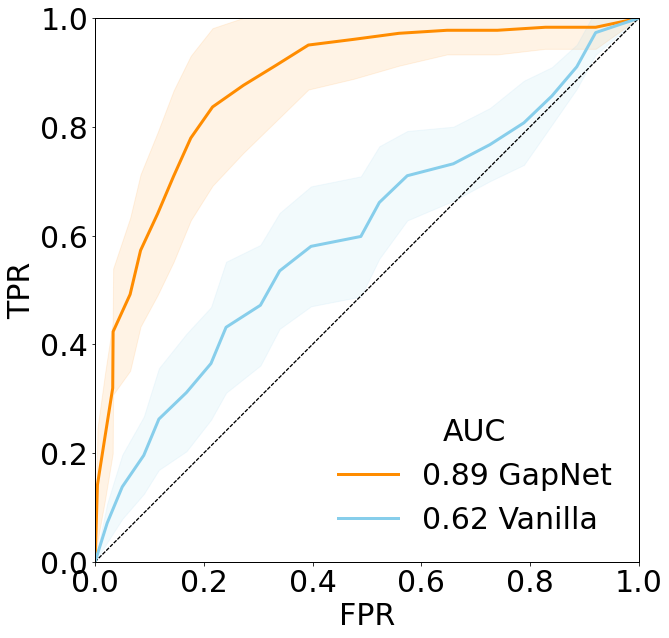

In [13]:
plot_roc_avg("0.89 GapNet", gapnet_val_y_labels, gapnet_val_y_preds, linestyle='solid', color='darkorange')
plot_roc_avg("0.62 Vanilla", vanilla_val_y_labels, vanilla_val_y_preds, linestyle='solid', color='skyblue')
leg = plt.legend(title="AUC",loc='lower right',fontsize= '30')
leg.get_frame().set_linewidth(0.0)
leg.get_title().set_fontsize(30)

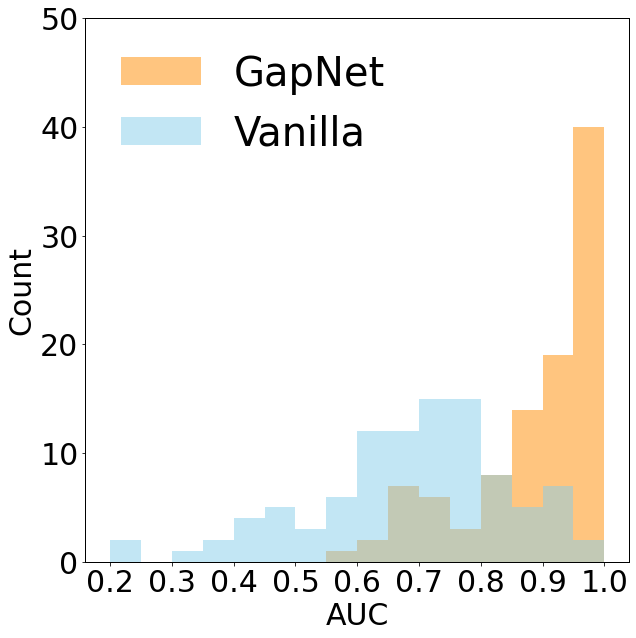

In [14]:
plt.hist(gapnet_val_aucs, label='GapNet', bins=[0.2, 0.25, 0.3, 0.35,0.4, 0.45, 0.5,0.55, 0.6, 0.65, 0.7,0.75, 0.8,0.85, 0.9,0.95,1.0], alpha=0.5, color='darkorange')
plt.hist(vanilla_val_aucs, label='Vanilla', bins=[0.2, 0.25, 0.3, 0.35,0.4, 0.45, 0.5,0.55, 0.6, 0.65, 0.7,0.75, 0.8,0.85, 0.9,0.95,1.0], alpha=0.5, color='skyblue')
ax = plt.gca()
ax.set_aspect('auto')
plt.xlabel('AUC', fontsize=30)
plt.ylabel('Count', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim([0,50])
leg = plt.legend(fontsize= '40')
leg.get_frame().set_linewidth(0.0)
leg.get_title().set_fontsize(40)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

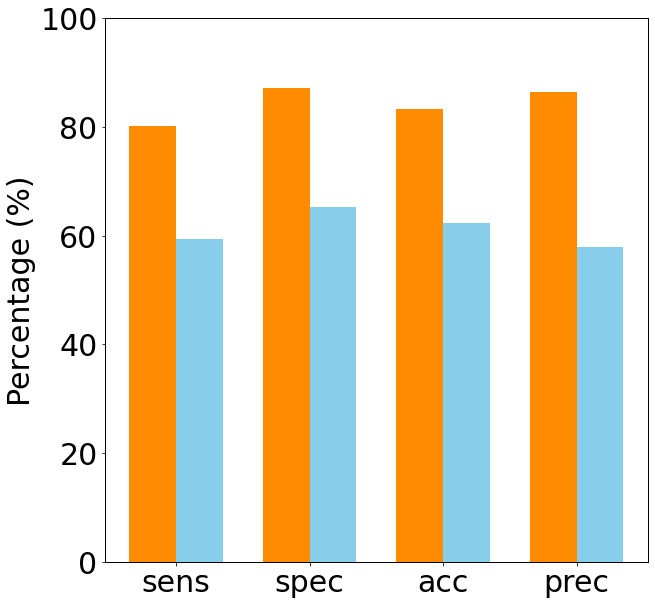

In [15]:
labels = ['sens', 'spec', 'acc', 'prec']
gapnet_means = [0.802*100,0.872*100,0.833*100,0.865*100]
vanilla_means = [0.593*100,0.653*100,0.623*100,0.580*100]
gapnet_std = [0.132*100,0.101*100,0.113*100,0.111*100]
vanilla_std = [0.169*100,0.139*100,0.130*100,0.212*100]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

ax.bar(x - width/2, gapnet_means, width, label='GapNet', color='darkorange')
ax.bar(x + width/2, vanilla_means, width, label='vanilla NN', color='skyblue')

#ax.legend()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim([0,100])
plt.ylabel('Percentage (%)', fontsize=30)
#leg = plt.legend(fontsize= '30')
#leg.get_frame().set_linewidth(0.0)
#leg.get_title().set_fontsize(30)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()

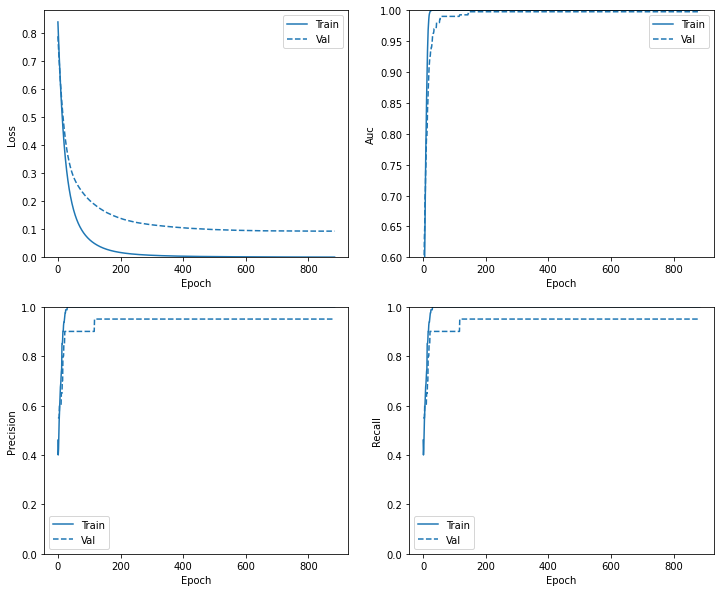

In [16]:
plot_metrics(gapnet_history)

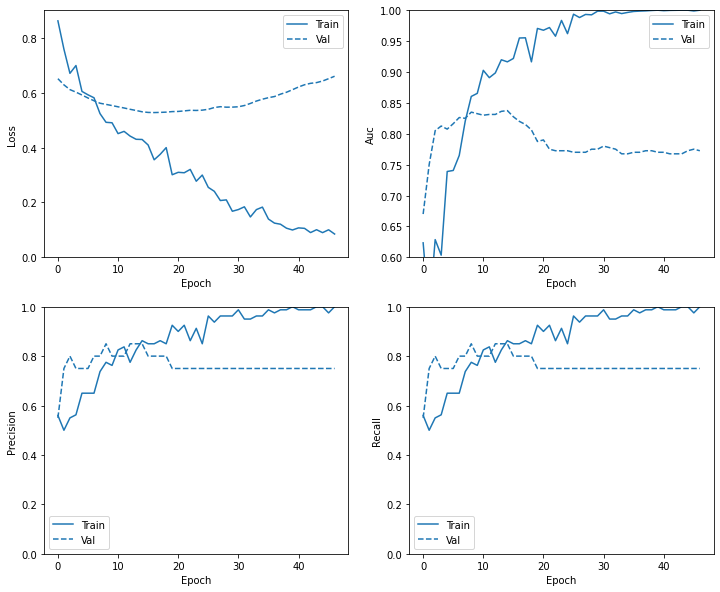

In [17]:
plot_metrics(vanilla_history)

Legitimate Transactions Detected (True Negatives):  850
Legitimate Transactions Incorrectly Detected (False Positives):  210
Fraudulent Transactions Missed (False Negatives):  125
Fraudulent Transactions Detected (True Positives):  815
Total Fraudulent Transactions:  940


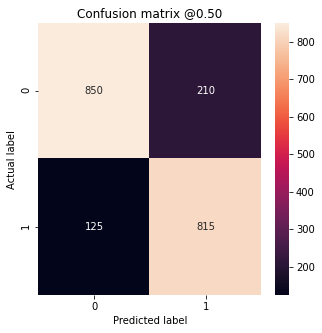

In [21]:
plot_cm(gapnet_val_y_labels, gapnet_val_y_preds, 0.5)

Legitimate Transactions Detected (True Negatives):  551
Legitimate Transactions Incorrectly Detected (False Positives):  329
Fraudulent Transactions Missed (False Negatives):  542
Fraudulent Transactions Detected (True Positives):  578
Total Fraudulent Transactions:  1120


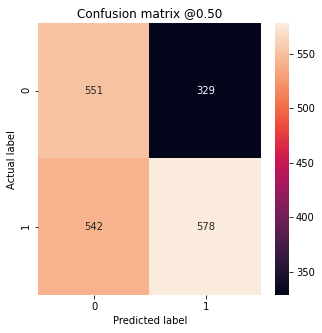

In [22]:
plot_cm(vanilla_val_y_labels, vanilla_val_y_preds, 0.5)

In [23]:
# perform delong test
def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    
def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))

#test https://biasedml.com/roc-comparison/
import scipy.stats as st
def group_preds_by_label(preds, actual):
    X = [p for (p, a) in zip(preds, actual) if a]
    Y = [p for (p, a) in zip(preds, actual) if not a]
    return X, Y
X_A, Y_A = group_preds_by_label(gapnet_val_y_preds, gapnet_val_y_labels)
X_B, Y_B = group_preds_by_label(vanilla_val_y_preds, vanilla_val_y_labels)
V_A10, V_A01 = structural_components(X_A, Y_A)
V_B10, V_B01 = structural_components(X_B, Y_B)
auc_A = auc(X_A, Y_A)
auc_B = auc(X_B, Y_B)
# Compute entries of covariance matrix S (covar_AB = covar_BA)
var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
         + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
         + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
            + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))
# Two tailed test
z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
p = st.norm.sf(abs(z))*2
print("z-score:", z)
print("p-value:", p)

z-score: 22.68035956738896
p-value: 7.001470541115719e-114
